In [10]:
!pip3 install tensorflow opencv-python mediapipe scikit_learn matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

2024-01-05 23:08:35.915431: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 23:08:35.917745: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 23:08:35.951439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 23:08:35.951473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 23:08:35.952757: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
mp_holistic=mp.solutions.holistic
mp_drawing=mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image,model):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable=False
    results=model.process(image)
    image.flags.writeable=True
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results
    

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
cap=cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret,frame=cap.read()

        image,results=mediapipe_detection(frame,holistic)

        draw_landmarks(image,results)

        cv2.imshow("Feed",image)

        if cv2.waitKey(10)==ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1704476323.436734   30446 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1704476323.440379   30508 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (ICL GT1)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/utkarsh/.local/lib/python3.10/site-packages/cv2/qt/plugins"


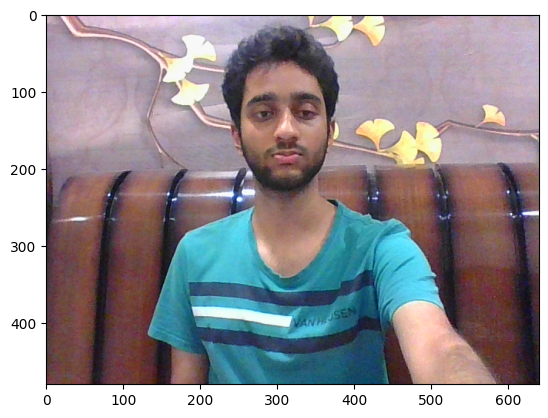

In [6]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [7]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [9]:
result_test = extract_keypoints(results)

In [10]:
DATA_PATH=os.path.join('MP_DATA')
actions=np.array(['hello','thanks','iloveyou'])
no_sequences=30
sequence_length=30

In [11]:
for action in actions: 
    for sequence in range(0,no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [12]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1704476460.752594   30446 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1704476460.754148   30573 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (ICL GT1)


In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
label_map = {label:num for num, label in enumerate(actions)}

In [15]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [16]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [19]:
log_dir=os.path.join('Logs')
tb_callback=TensorBoard(log_dir=log_dir)

In [20]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [86]:
res=[.7,0.2,0.1]

In [87]:
actions[np.argmax(res)]

'hello'

In [23]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [24]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 4s 71ms/step - loss: 10.1620 - categorical_accuracy: 0.3059
Epoch 2/2000
3/3 [==============================] - 0s 65ms/step - loss: 28.7355 - categorical_accuracy: 0.2471
Epoch 3/2000
3/3 [==============================] - 0s 64ms/step - loss: 172.9896 - categorical_accuracy: 0.4353
Epoch 4/2000
3/3 [==============================] - 0s 65ms/step - loss: 138.2114 - categorical_accuracy: 0.3176
Epoch 5/2000
3/3 [==============================] - 0s 65ms/step - loss: 71.1667 - categorical_accuracy: 0.3529
Epoch 6/2000
3/3 [==============================] - 0s 63ms/step - loss: 94.0636 - categorical_accuracy: 0.2941
Epoch 7/2000
3/3 [==============================] - 0s 67ms/step - loss: 61.3786 - categorical_accuracy: 0.2824
Epoch 8/2000
3/3 [==============================] - 0s 63ms/step - loss: 53.6850 - categorical_accuracy: 0.2471
Epoch 9/2000
3/3 [==============================] - 0s 62ms/step - loss: 35.9401 - categorical_accurac

KeyboardInterrupt: 

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 596675 

In [88]:
res = model.predict(X_train)

3/3 [==============================] - 0s 21ms/step


In [89]:
actions[np.argmax(res[4])]

'thanks'

In [90]:
actions[np.argmax(y_train[4])]

'thanks'

In [29]:
model.save('action.h5')

/home/utkarsh/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [91]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

yhat = model.predict(X_train)

ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

multilabel_confusion_matrix(ytrue, yhat)

3/3 [==============================] - 0s 19ms/step


array([[[56,  0],
        [ 4, 25]],

       [[55,  1],
        [ 0, 29]],

       [[54,  4],
        [ 1, 26]]])

In [92]:
accuracy_score(ytrue, yhat)

0.9411764705882353

In [93]:
len(res)

85

In [94]:
np.argmax(res)

68

In [103]:
res[np.argmax(res)]

array([9.9999523e-01, 2.0619766e-25, 4.7559051e-06], dtype=float32)

In [113]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [119]:
sequence=[]
sentence=[]
threshold=0.8

cap=cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret,frame=cap.read()

        image,results=mediapipe_detection(frame,holistic)

        draw_landmarks(image,results)

        keypoints=extract_keypoints(results)
        sequence.insert(0,keypoints)
        sequence=sequence[:30]

        if len(sequence)==30:
            res=model.predict(np.expand_dims(sequence,axis=0))[0]
            print(actions[np.argmax(res)])

        if (res[np.argmax(res)] > threshold) :
            if len(sentence) > 0:
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.append(actions[np.argmax(res)])
            else:
                sentence.append(actions[np.argmax(res)])

        # if len(sentence) > 5 :
        #     sentence=sentence[-5:]

        image = prob_viz(res, actions, image, colors)

        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow("Feed",image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1704481237.801949   30446 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1704481237.803043   69055 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: Mesa Intel(R) UHD Graphics (ICL GT1)


1/1 [==============================] - 0s 21ms/step
iloveyou
1/1 [==============================] - 0s 20ms/step
iloveyou
1/1 [==============================] - 0s 22ms/step
iloveyou
1/1 [==============================] - 0s 21ms/step
iloveyou
1/1 [==============================] - 0s 21ms/step
iloveyou
1/1 [==============================] - 0s 21ms/step
iloveyou
1/1 [==============================] - 0s 23ms/step
iloveyou
1/1 [==============================] - 0s 22ms/step
iloveyou
1/1 [==============================] - 0s 22ms/step
iloveyou
1/1 [==============================] - 0s 24ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
iloveyou
1/1 [==============================] - 0s 21ms/step
iloveyou
1/1 [==============================] - 

In [108]:
cap.release()
cv2.destroyAllWindows()

In [106]:
res[np.argmax(res)]>threshold

array([ True, False, False])

In [120]:
sentence

['iloveyou',
 'hello',
 'iloveyou',
 'hello',
 'iloveyou',
 'hello',
 'iloveyou',
 'thanks',
 'iloveyou',
 'hello',
 'iloveyou',
 'hello']

In [122]:
my_sentence=sentence

In [123]:
%store my_sentence

Stored 'my_sentence' (list)


/home/utkarsh/.local/lib/python3.10/site-packages/IPython/extensions/storemagic.py:229: UserWarning: using autorestore/my_sentence requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj
